# Generate initial designs for training data for ART

In [2]:
import numpy as np
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt

# from ipywidgets import interact, widgets

All genes we might consider in relation to isopentenol production:

In [3]:
genes = ['ACCOAC', 
         'POX', 
         'PTAr', 
         'CS', 
         'ACACT1R', 
         'PPC', 
         'PPCK', 
         'PFL', 
         'PYK', 
         'MDH']

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

In [4]:
modif_dict = {'KO': 0, 
              'NoMod': 1,
              'UP': 2}

How many genes you want to consider?

In [5]:
n_genes = int(input())


 8


How many instances you want to generate?

In [6]:
n_instances = int(input())

 100


In [7]:
n_modifications = len(modif_dict)
genes = genes[:n_genes]
tot_number_mod = n_modifications**n_genes
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 100 (1.52%)


In [8]:
df = pd.DataFrame(columns=genes)
df.insert(loc=0, column='Line Name', value=None)

Define wild type strain with no modifications:

In [10]:
df.loc[0] = ['WT'] + [modif_dict['NoMod'] for i in range(n_genes)] 
df

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPC,PPCK,PFL
0,WT,1,1,1,1,1,1,1,1


### Assign designs for the training set randomly

In [11]:
for i in range(1,n_instances):
    df.loc[i] = [str(i)] + [randrange(3) for i in range(n_genes)]
                            
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPC,PPCK,PFL
0,WT,1,1,1,1,1,1,1,1
1,1,1,0,1,2,0,2,0,2
2,2,2,2,0,0,0,0,1,0
3,3,1,1,1,2,0,2,1,1
4,4,2,1,2,0,1,0,2,1


How many modifications 'introduced' into each strain?

In [12]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [13]:
df['# Modifs'] = num_of_modifications(df)
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPC,PPCK,PFL,# Modifs
0,WT,1,1,1,1,1,1,1,1,0.0
1,1,1,0,1,2,0,2,0,2,6.0
2,2,2,2,0,0,0,0,1,0,7.0
3,3,1,1,1,2,0,2,1,1,3.0
4,4,2,1,2,0,1,0,2,1,5.0


Find distribution of modifications per gene in the training data set:

In [25]:
df.loc[(n_instances+1)] = ['Summary'] + [[list(df[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name                             Summary
ACCOAC       [34.0, 28.999999999999996, 37.0]
POX                        [32.0, 32.0, 36.0]
PTAr                       [27.0, 39.0, 34.0]
CS                         [35.0, 32.0, 33.0]
ACACT1R      [33.0, 28.999999999999996, 38.0]
PPC          [39.0, 28.999999999999996, 32.0]
PPCK                       [39.0, 31.0, 30.0]
PFL          [28.000000000000004, 34.0, 38.0]
# Modifs                                 5.45
Name: 101, dtype: object

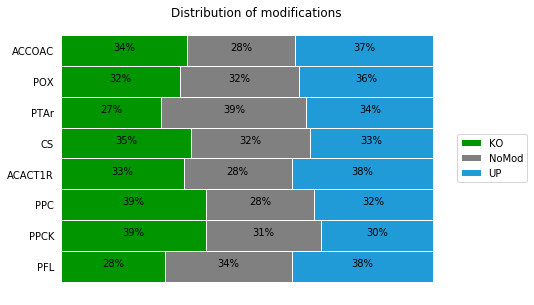

In [26]:
bar_height = 1
labels = ['KO', 'NoMod', 'UP']
# segments = len(labels)
colors = ['#019600', 'grey', '#219AD8']

data = [ [df[df['Line Name']=='Summary'][g].values[0][num] for g in genes] 
        for num in range(n_modifications)]
y_pos = np.arange(len(genes))

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)

# Remove frame
for spine in plt.gca().spines.values():
    spine.set_visible(False)

patch_handles = []
# left alignment of data starts at zero
left = np.zeros(len(genes)) 
for i, d in enumerate(data):
    patch_handles.append(ax.barh(y_pos, d, 
                                 color=colors[i%len(colors)], edgecolor='white',
                                 height=bar_height, align='center', 
                                 left=left, label=labels[i]))
    left += d

# search all of the bar segments and annotate
for j in range(n_modifications):
    for i, patch in enumerate(patch_handles[j].get_children()):
        bl = patch.get_xy()
        x = 0.5*patch.get_width() + bl[0]
        y = 0.5*patch.get_height() + bl[1]
        ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

ax.set_title('Distribution of modifications')
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                labelbottom='off')
plt.yticks(y_pos, genes)
ax.invert_yaxis()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


Save training set:

In [17]:
df.loc[0:n_instances].to_csv(f'./data/training_data_{n_genes}genes.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)